In [1]:
import pandas as pd
import numpy as np
import math
import warnings
warnings.filterwarnings('ignore')

# visuals
import seaborn as sns
import matplotlib.pyplot as plt

# Support Functions

In [2]:
def get_df_null_info(df):
    '''analzyse sparse columns (= many NaNs/Null-Values)'''
    nulls:pd.Series =df.isnull().sum(axis = 0).sort_values(ascending = False)
    df_null_info:pd.DataFrame = pd.DataFrame(data={
        'nulls_amount': nulls,
        'nulls_percentage': nulls.apply(lambda row: round((row/df.shape[0])*100,2))
    })
    return df_null_info

def get_info_about_price(df):
    mean = math.floor(df[col_y].mean())
    max = math.floor(df[col_y].max())
    print(f"Mean of 'Price' = {mean}\t\t Max of 'Price' = {max}")

# Get to know the data

In [3]:
# load dataset
df_source = pd.read_csv("germany_housing_data_14.07.2020.csv", sep=",")

# check how many null values are inside of dataset
df_null_info = get_df_null_info(df_source)
df_null_info
col_y = "Price"

In [4]:
# get some statistical information about dataset
df_source.describe(include="all")
get_info_about_price(df_source)

Mean of 'Price' = 556685		 Max of 'Price' = 13000000


# Pre-Processing

### Data Reduction (Dimensionality Reduction)

In [5]:
# Drop all columns:
#  (a) with more than 30% null values
#  (b) 'City' & 'Place' because  'State', 'City', and 'Place' have same information but with different granularity
drop_col_percentage_treshold=26
cols_to_drop = list(df_null_info[(df_null_info['nulls_percentage'] > drop_col_percentage_treshold)].index.values) 
cols_to_drop.append('City')
cols_to_drop.append('Place')
print(f'Drop following columns: {cols_to_drop}')

df_source.drop(columns=cols_to_drop, inplace=True)

Drop following columns: ['Energy_consumption', 'Year_renovated', 'Usable_area', 'Energy_efficiency_class', 'Bedrooms', 'Free_of_Relation', 'Energy_certificate_type', 'City', 'Place']


### Data Cleaning (handle missing data)

In [6]:
df_null_info = get_df_null_info(df_source)
df_null_info

,nulls_amount,nulls_percentage
Furnishing_quality,2726,25.83
Floors,2664,25.25
Garagetype,1960,18.57
Garages,1960,18.57
Bathrooms,1801,17.07
Energy_source,1227,11.63
Energy_certificate,755,7.16
Year_built,694,6.58
Heating,584,5.53
Type,402,3.81


Start to clean each column.

In [7]:
# for column 'State' drop all rows with no state
df_source.drop(df_source[df_source['State'].isnull()].index, inplace=True)
df_source.loc[df_source['State'].isnull()]

# for all other columns: fill NaNs with mode value
for col in df_source:
    df_source[col].fillna(df_source[col].mode()[0], inplace=True)

In [8]:
df_source.sample(2)

,Unnamed: 0,Price,Type,Living_space,Lot,Rooms,Bathrooms,Floors,Year_built,Furnishing_quality,Condition,Heating,Energy_source,Energy_certificate,State,Garages,Garagetype
8504,8504,465000.0,Mid-terrace house,152.0,416.0,4.0,2.0,3.0,1978.0,normal,fixer-upper,heat pump,Gas,not required by law,Rheinland-Pfalz,1.0,Garage
4377,4377,498000.0,Multiple dwelling,106.0,229.0,5.5,1.0,2.0,2005.0,normal,modernized,central heating,Gas,available,Baden-Württemberg,2.0,Parking lot


### Data Cleaning (Outlier Removal)

In [9]:
df_source.dtypes

Unnamed: 0              int64
Price                 float64
Type                   object
Living_space          float64
Lot                   float64
Rooms                 float64
Bathrooms             float64
Floors                float64
Year_built            float64
Furnishing_quality     object
Condition              object
Heating                object
Energy_source          object
Energy_certificate     object
State                  object
Garages               float64
Garagetype             object
dtype: object

In [10]:
## remove outlier: z_score transformation

# get all numerical columns
cols_to_zscore = list(df_source.select_dtypes(include='float64'))
cols_zscore = []

# create df with zscore-columns 
for col in cols_to_zscore:
    col_zscore = col + '_zscore'
    cols_zscore.append(col_zscore)
    
    # zscore of x in column :    (x- col.mean)-col.std
    # -> add an extra column for zscore
    df_source[col_zscore] = (df_source[col] - df_source[col].mean())/df_source[col].std(ddof=0)

In [11]:
cols_zscore

['Price_zscore',
 'Living_space_zscore',
 'Lot_zscore',
 'Rooms_zscore',
 'Bathrooms_zscore',
 'Floors_zscore',
 'Year_built_zscore',
 'Garages_zscore']

In [12]:
treshhold = 3
treshhold_range = [-treshhold, treshhold]

df_source["max_zscore"] = df_source[cols_zscore].max(axis=1) 
df_source['min_zscore'] = df_source[cols_zscore].min(axis=1) 


df_source['is_outlier_zscore'] = (
    (treshhold <= df_source["max_zscore"]) | 
    (df_source["max_zscore"] <= -treshhold ) | 

    (treshhold  <= df_source["min_zscore"]) | 
    (df_source["min_zscore"]  <= -treshhold )
)

amount_of_outliers = len(df_source[df_source['is_outlier_zscore'] == True])
print(f"Detected {amount_of_outliers} rows as outliers.")

Detected 715 rows as outliers.


Mean of 'Price' = 487956		 Max of 'Price' = 2350000


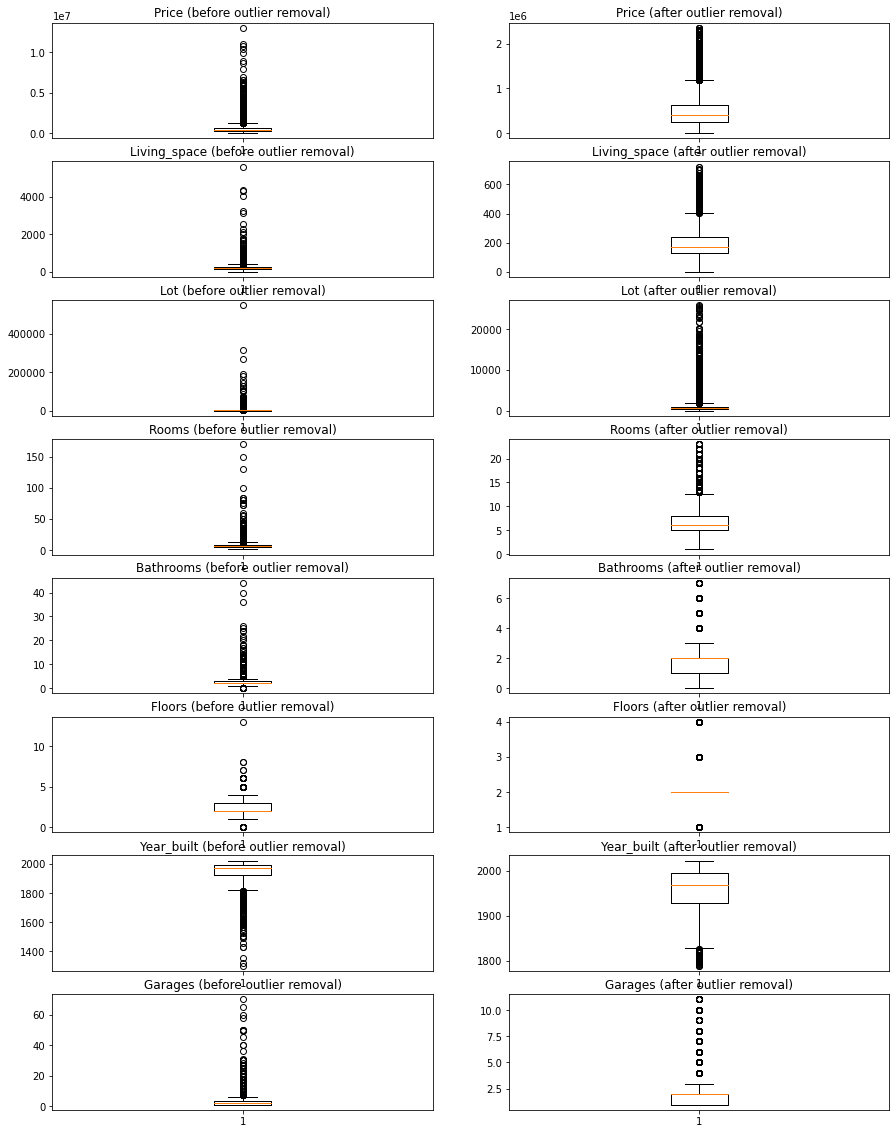

In [13]:

df_new = df_source[df_source['is_outlier_zscore'] == False]
fig = plt.figure( figsize=(15, 20))
id=1
for i in range(0,len(cols_to_zscore)):
    col = cols_to_zscore[i] 

    # old one
    ax = fig.add_subplot(8,2,id)
    ax.boxplot(df_source[col])
    ax.set_title(f"{col} (before outlier removal)")
    id=id+1

    # new one
    ax = fig.add_subplot(8,2,id)
    ax.boxplot(df_new[col])
    ax.set_title(f"{col} (after outlier removal)")
    id=id+1

get_info_about_price(df_new)

In [14]:
### drop zscore cols
df_source = df_new.drop(columns= [col for col in df_new.columns if col.endswith('_zscore')])
df_source.columns

Index(['Unnamed: 0', 'Price', 'Type', 'Living_space', 'Lot', 'Rooms',
       'Bathrooms', 'Floors', 'Year_built', 'Furnishing_quality', 'Condition',
       'Heating', 'Energy_source', 'Energy_certificate', 'State', 'Garages',
       'Garagetype'],
      dtype='object')

### Data Transformation (One-hot encoding)

In [15]:
cols_categorical = list(df_source.select_dtypes(include='object'))
cols_categorical

['Type',
 'Furnishing_quality',
 'Condition',
 'Heating',
 'Energy_source',
 'Energy_certificate',
 'State',
 'Garagetype']

In [16]:
def one_hot(df, cols):
    """
    @param df pandas DataFrame
    @param cols a list of categorical columns to encode 
    @return a DataFrame with one-hot encoding
    """
    for col in cols:
        # new df of one hot values
        one_hot = pd.get_dummies(df[col], prefix=col, drop_first=False)
        # Drop column B as it is now encoded
        df = df.drop(col ,axis = 1)
        # Join the encoded df
        df = df.join(one_hot)

    return df

df_source = one_hot(df_source, cols_categorical)
df_source.columns = df_source.columns.str.replace(' ','-')
df_source = df_source.drop(columns='Unnamed:-0')
df_source.sample(3)

,Price,Living_space,Lot,Rooms,Bathrooms,Floors,Year_built,Garages,Type_Bungalow,Type_Castle,...,State_Sachsen-Anhalt,State_Schleswig-Holstein,State_Thüringen,Garagetype_Car-park-lot,Garagetype_Carport,Garagetype_Duplex-lot,Garagetype_Garage,Garagetype_Outside-parking-lot,Garagetype_Parking-lot,Garagetype_Underground-parking-lot
5260,249000.0,200.0,402.0,6.0,2.0,1.0,1958.0,3.0,0,0,...,0,0,0,0,0,0,0,0,1,0
3109,398000.0,137.0,446.0,4.0,2.0,1.0,2004.0,1.0,0,0,...,0,0,0,0,0,0,1,0,0,0
8350,169000.0,210.0,162.0,8.0,2.0,4.0,1900.0,1.0,0,0,...,0,0,0,0,0,0,1,0,0,0


### Data Transformation (Rearrange Dataframe)

In [17]:
# split into X and Y
col_y = "Price"
df_y:pd.DataFrame = df_source.drop(df_source.columns.difference([col_y]), 1)
df_X:pd.DataFrame = df_source.drop(columns=col_y)
df_source = pd.concat([df_X, df_y], axis=1, join='inner')
df_source.sample(2)

,Living_space,Lot,Rooms,Bathrooms,Floors,Year_built,Garages,Type_Bungalow,Type_Castle,Type_Corner-house,...,State_Schleswig-Holstein,State_Thüringen,Garagetype_Car-park-lot,Garagetype_Carport,Garagetype_Duplex-lot,Garagetype_Garage,Garagetype_Outside-parking-lot,Garagetype_Parking-lot,Garagetype_Underground-parking-lot,Price
6829,226.00,1444.0,10.0,2.0,2.0,1962.0,2.0,0,0,0,...,0,0,0,0,0,0,1,0,0,399000.0
107,244.71,835.0,5.0,2.0,2.0,1974.0,2.0,0,0,0,...,0,0,0,0,0,1,0,0,0,599000.0


### Data Reduction (Feature Selection)

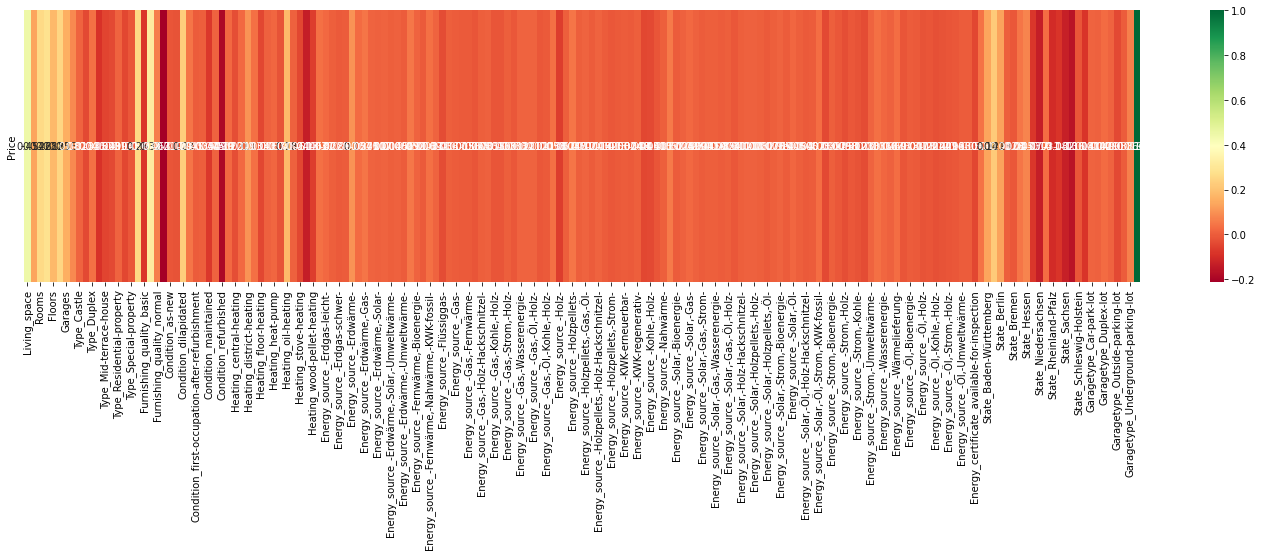

In [18]:
'''
Plot correlation between price and all features to get an idea what kind of features have an impact.
'''
# plot heat map showing features which have biggest effect on price
plt.figure(figsize=(25,5))
g=sns.heatmap(df_source.corr().loc[[col_y],:],annot=True,cmap="RdYlGn")

### Scale column

In [19]:
# from sklearn.preprocessing import StandardScaler
# 
# k = 3
# # only scale columns which are not one hot encoded
# scaler = StandardScaler().fit(X_train[:,:k])
# 
# def preprocessor(X):
#   A = np.copy(X)
#   A[:, :k] = scaler.transform(A[:, :k])
#   return A
# 
# X_train, X_test = preprocessor(X_train), preprocessor(X_test)

# Learning Algorithms

In [72]:
import math

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse 

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor # a lot of Decision Trees
from sklearn.neighbors import KNeighborsRegressor

def get_top_features(df, col_y="Price", min_corr_factor=0.2):
    ''' DATA REDUCTION: Feature Selection
    Select best (high correlation) features from data set
    '''
    cor = df.corr()
    cor_target = abs(cor[col_y])

    # get most significant features which correlate with output-variable y
    relevant_features = cor_target[cor_target > min_corr_factor]
    selected_features = list(relevant_features.index)
    print(f"These are selected features: {selected_features}")

    return selected_features


def split_df_into_train_test(df):
    ''' DATA TRANSFORMATION
    split dataframe into training and test data
    '''
    X = df.to_numpy()[:, :-1]
    y = df.to_numpy()[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    #print(f"Shapes for train/test/val:\t {X_train.shape}, {y_train.shape} / {X_test.shape}, {y_test.shape}")
    return X_train, X_test, y_train, y_test

def calc_loss(model, X, y):
    '''calculate loss of a model'''
    return math.floor(mse(model.predict(X), y, squared=False))

### Experiment 1: Plot Model for different top features

These are selected features: ['Living_space', 'Rooms', 'Bathrooms', 'Type_Villa', 'Furnishing_quality_luxus', 'Price']


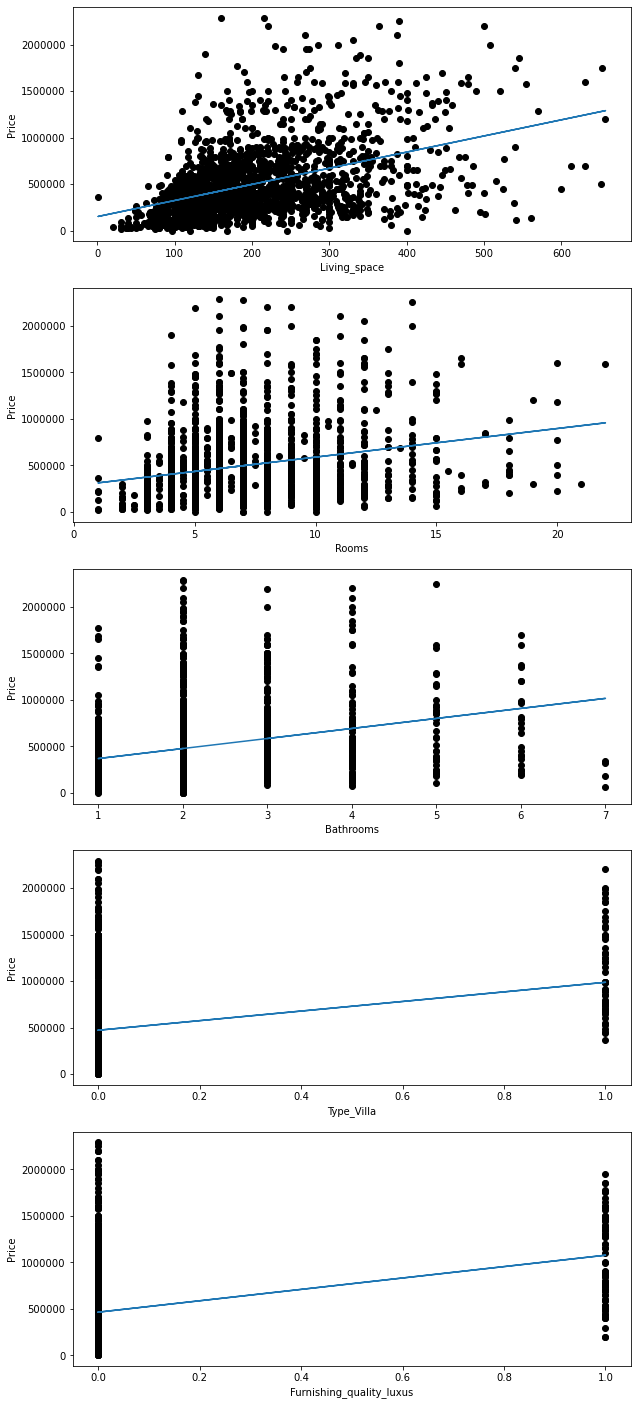

In [76]:
# calc list of top features
list_top_features = get_top_features(df=df_source, min_corr_factor=0.25)
list_top_features.remove(col_y)


list_loss_train = []
list_loss_test = []

fig, axs = plt.subplots(nrows=len(list_top_features))
fig.set_figheight(len(list_top_features)*5)
fig.set_figwidth(10)


for i, feature in enumerate(list_top_features):
    # create dataframe only with one feature
    df_model = df_source.drop(columns=df_source.columns.difference([feature, col_y]))

    # split dataframe into train & test
    X_train, X_test, y_train, y_test = split_df_into_train_test(df=df_model)

    # train linear regression model
    model_linear = LinearRegression().fit(X_train, y_train)

    # calc loss (MSE) for train & test
    loss_train = calc_loss(model_linear, X_train, y_train)
    loss_test  = calc_loss(model_linear, X_test, y_test)

    list_loss_train.append(loss_train)
    list_loss_test.append(loss_test)

    # plot 
    y_pred = model_linear.predict(X_test)
    axs[i].ticklabel_format(useOffset=False)
    axs[i].scatter(X_test, y_test, color="black")
    axs[i].plot(X_test, y_pred)
    axs[i].ticklabel_format(style='plain')
    axs[i].set_xlabel(f'{feature}')
    axs[i].set_ylabel(f'{col_y}')



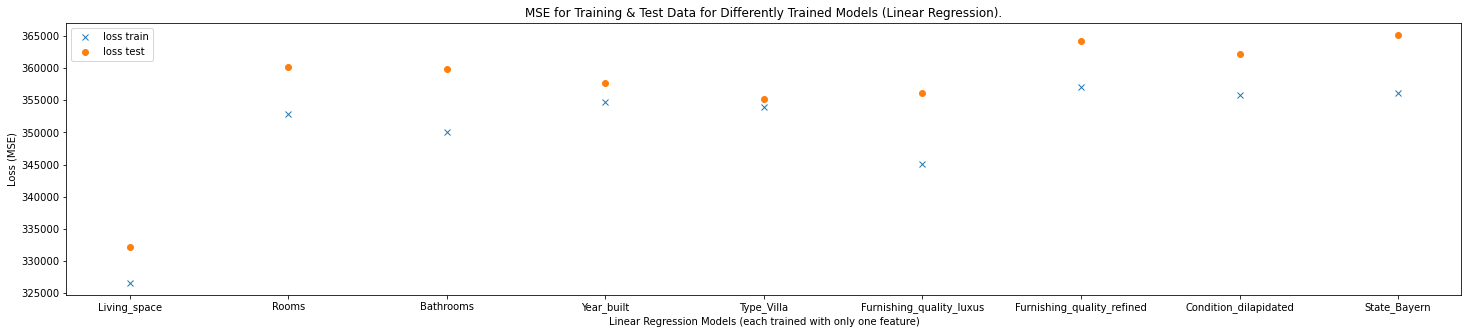

In [66]:

fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(25)
ax.plot(list_top_features, list_loss_train, label="loss train", linestyle = 'None', marker="x")
ax.plot(list_top_features, list_loss_test, label="loss test", linestyle = 'None', marker="o")
ax.legend()
ax.set_title("MSE for Training & Test Data for Differently Trained Models (Linear Regression).")
ax.set_xlabel("Linear Regression Models (each trained with only one feature)")
ax.set_ylabel("Loss (MSE)")
plt.show()

In [105]:
'''
EXPERIMENT 2: Look at score difference for different amount of features
'''

mtrx_loss_train = [[],[],[]]
mtrx_loss_test  = [[],[],[]]


for i, feature in enumerate(list_top_features):
     # create dataframe only with one feature
    cols = list_top_features[:i+1]
    cols.append(col_y)
    df_model = df_source.drop(columns=df_source.columns.difference(cols))

    # split dataframe into train & test
    X_train, X_test, y_train, y_test = split_df_into_train_test(df=df_model)

    # model = linear regression
    model_linear = LinearRegression().fit(X_train, y_train)
    mtrx_loss_train[0].append(calc_loss(model_linear, X_train, y_train))
    mtrx_loss_test[0].append(calc_loss(model_linear, X_test, y_test))
    
    # model = knn
    model_knn = KNeighborsRegressor(n_neighbors=20).fit(X_train, y_train)
    mtrx_loss_train[1].append(calc_loss(model_knn, X_train, y_train))
    mtrx_loss_test[1].append(calc_loss(model_knn, X_test, y_test))

    # model = random forest
    model_rfr = RandomForestRegressor(max_depth=2).fit(X_train, y_train)
    mtrx_loss_train[2].append(calc_loss(model_rfr, X_train, y_train))
    mtrx_loss_test[2].append(calc_loss(model_rfr, X_test, y_test))

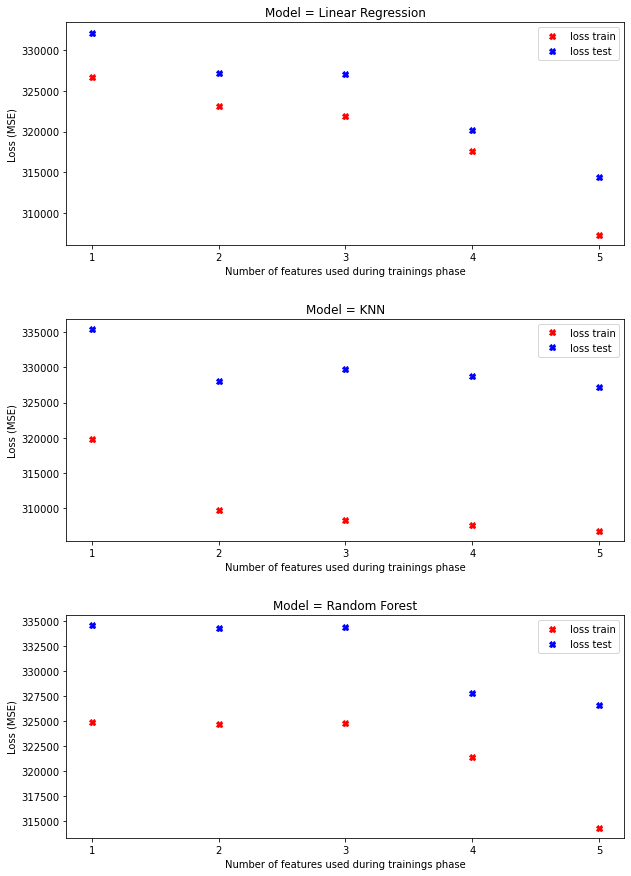

In [128]:

list_number_features = np.arange(1, len(list_top_features)+1, 1)
list_models = ["Linear Regression", "KNN", "Random Forest"]
fig, axs = plt.subplots(len(list_models))
fig.set_figheight(len(list_models)*5)
fig.set_figwidth(10)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.33)

for i, model in enumerate(list_models):
    axs[i].plot(list_number_features, mtrx_loss_train[i], label="loss train", linestyle = 'None', marker="X", color="r")
    axs[i].plot(list_number_features, mtrx_loss_test[i], label="loss test", linestyle = 'None', marker="X", color="b")
    
    axs[i].xaxis.set_ticks(list_number_features)
    
    axs[i].set_xlabel(f'Number of features used during trainings phase')
    axs[i].set_title(f'Model = {model}')
    axs[i].set_ylabel(f'Loss (MSE)')
    axs[i].legend()
    
plt.show()
